In [285]:
#Import all of the necessary packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.html.widgets import interact, fixed
import ipywidgets as widgets

import io

font_plt = {'family': 'serif',
            'color':  'darkred',
            'weight': 'normal',
            'size': 12,
            }
font_plt_ax = {'family': 'serif',
               'color':  'black',
               'weight': 'normal',
               'size': 12,
              }
import sys
import glob #glob is helpful for searching for filenames or directories
import ddm_clean as ddm #this is the module containing the differential dynamic microscopy code
import scipy #scientific python
from scipy.signal import blackmanharris as bh #for Blackman-Harris windowing
import pickle #for saving data


In [242]:
condition=["Actin_myosin","AMT_myosin"]
c_key=0
stimulation={"nostim":"nostim","405stim":"405stim"}
fit = ["ExpoFit","TwoModeFit"]
root_directory= 'Y:\\Jon_Garamella\\data\\active_networks\\videos_date\\2020-07-29\\%s\\ddm_analysis\\' %condition[c_key]

In [256]:
expo_data = {}
file_matching = "\\*NormalizedISFFitting_"+fit[0]+".p"
for c in stimulation.keys():
    pickle_files_to_load = glob.glob(root_directory+stimulation[c]+file_matching)
    for i,filename in enumerate(pickle_files_to_load):
        f = open(filename,'rb') #open file for reading
        pickled_data = pickle.load(f) #load data from file
        f.close()
        
        #for each condition, initialize an emtpy dictionary
        # just want to initialize once
        if i==0:
            expo_data[c] = {} #make sub-dictionary for this condition
            
        expo_data[c][(pickled_data['Movie'],pickled_data['ROI'])] = pickled_data
        
twomode_data = {}
file_matching = "\\*NormalizedISFFitting_"+fit[1]+".p"
for c in stimulation.keys():
    pickle_files_to_load = glob.glob(root_directory+stimulation[c]+file_matching)
    for i,filename in enumerate(pickle_files_to_load):
        f = open(filename,'rb') #open file for reading
        pickled_data = pickle.load(f) #load data from file
        f.close()
        
        #for each condition, initialize an emtpy dictionary
        # just want to initialize once
        if i==0:
            twomode_data[c] = {} #make sub-dictionary for this condition
            
        twomode_data[c][(pickled_data['Movie'],pickled_data['ROI'])] = pickled_data

In [257]:
print "expo stim data (movie, ROI):", expo_data['405stim'].keys()
print "expo nostim data:", expo_data['nostim'].keys()
print "two mode stim data (movie, ROI):", twomode_data['405stim'].keys()
#print "two mode nostim data (movie, ROI):", twomode_data['nostim'].keys()


expo stim data (movie, ROI): [(1, 0)]
expo nostim data: [(4, 0)]
two mode stim data (movie, ROI): [(1, 512), (1, 768), (1, 0), (1, 256)]


## First we'll plot some stimulated data to compare the two models

<IPython.core.display.Javascript object>


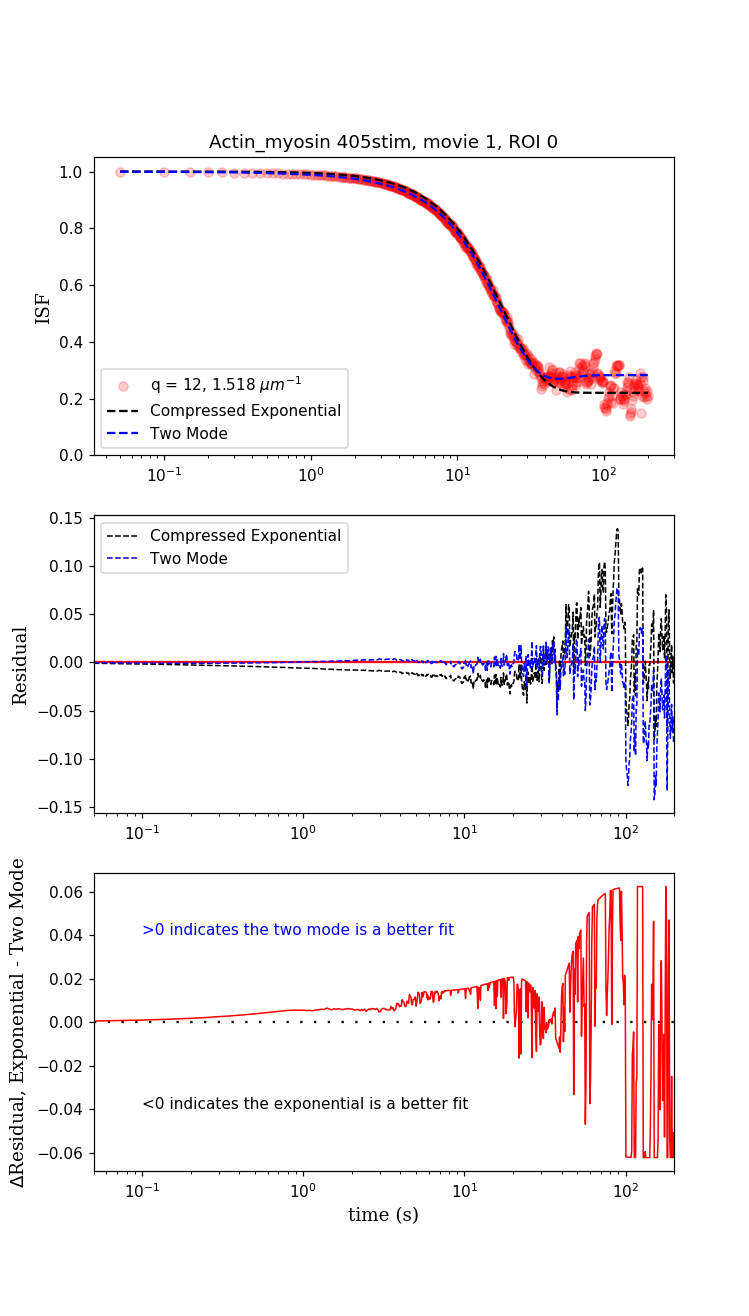

In [312]:
%matplotlib notebook
plt.figure(figsize=((6,3*6/1.618)))

########################

q_index=12
stimkey="405stim"
movie=1
ROI=0

########################

qs=expo_data[stimkey][(movie,ROI)]['qs']
qss=twomode_data[stimkey][(movie,ROI)]['qs']
time=expo_data[stimkey][(movie,ROI)]['times']

isf=twomode_data[stimkey][(movie,ROI)]['ISF'][:,q_index]
expo_c=expo_data[stimkey][(movie,ROI)]['c']
expo_s=expo_data[stimkey][(movie,ROI)]['stretching_exponent']
expo_tau=expo_data[stimkey][(movie,ROI)]['tau']

twomode_c=twomode_data[stimkey][(movie,ROI)]['c']
twomode_td=twomode_data[stimkey][(movie,ROI)]['tau_diff']
twomode_s=twomode_data[stimkey][(movie,ROI)]['stretching_exponent']
twomode_tb=twomode_data[stimkey][(movie,ROI)]['tau_ball']
twomode_apop=twomode_data[stimkey][(movie,ROI)]['a_ballistic_prop']
twomode_z=twomode_data[stimkey][(movie,ROI)]['schulz']

plt.subplot(3,1,1)
plt.title("%s %s, movie %i, ROI %i" %(condition[c_key],stimkey, movie, ROI))
plt.semilogx(time, isf, "ro", alpha=.2,label="q = %i, %.3f $\mu m^{-1}$" %(q_index,qs[q_index]))
plt.semilogx(time, ddm.dTheoryNonErgISF(time, expo_c[q_index], expo_tau[q_index], expo_s[q_index]), 
             "--k", lw=1.5,label="Compressed Exponential")
plt.semilogx(time,ddm.dTheoryTwoModeISF(time,twomode_c[q_index],twomode_td[q_index],twomode_s[q_index],
                                        twomode_tb[q_index],twomode_apop[q_index],twomode_z[q_index]), 
             '--b', lw=1.5,label="Two Mode")
plt.ylabel("ISF", font_plt_ax)
plt.ylim(0,1.05)

plt.legend()



plt.subplot(3,1,2)
plt.semilogx(time, isf-ddm.dTheoryNonErgISF(time, expo_c[q_index], expo_tau[q_index], expo_s[q_index]), 
             "--k", lw=1,label="Compressed Exponential")
plt.plot(time,isf-ddm.dTheoryTwoModeISF(time,twomode_c[q_index],twomode_td[q_index],twomode_s[q_index],
                                        twomode_tb[q_index],twomode_apop[q_index],twomode_z[q_index]), 
             '--b', lw=1,label="Two Mode")
plt.hlines(0,time[0],time[-1], colors='r')
plt.ylabel("Residual",font_plt_ax)
plt.xlim(0,time[-1])
plt.legend()

plt.subplot(3,1,3)
plt.semilogx(time, np.absolute(isf-ddm.dTheoryNonErgISF(time, expo_c[q_index], expo_tau[q_index], expo_s[q_index]))-
         np.absolute(isf-ddm.dTheoryTwoModeISF(time,twomode_c[q_index],twomode_td[q_index],twomode_s[q_index],
                                        twomode_tb[q_index],twomode_apop[q_index],twomode_z[q_index])),"-r", 
         lw=1)
plt.text(.1, 0.04, ">0 indicates the two mode is a better fit", color="b")
plt.text(.1, -0.04, "<0 indicates the exponential is a better fit", color="k")
plt.ylabel("$\Delta$Residual, Exponential - Two Mode", font_plt_ax)
plt.xlabel("time (s)",font_plt_ax)
plt.xlim(0,time[-1])

plt.hlines(0,time[0],time[-1], linestyles=(0, (1, 5)))

<IPython.core.display.Javascript object>


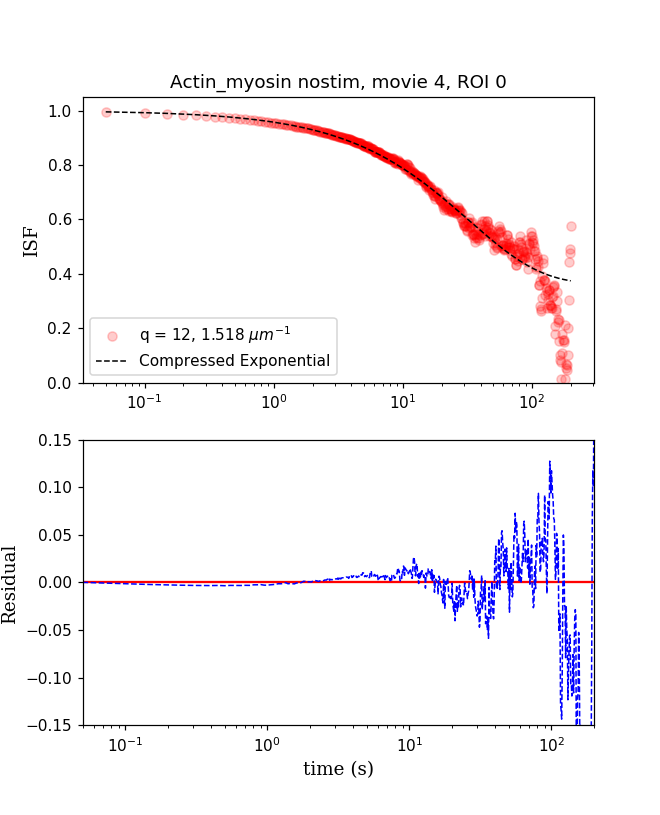

Text(0.5,0,'time (s)')

In [313]:
%matplotlib notebook
plt.figure(figsize=((6,2*6/1.618)))

########################

q_index=12
stimkey="nostim"
movie=4
ROI=0

########################

qs=expo_data[stimkey][(movie,ROI)]['qs']
time=expo_data[stimkey][(movie,ROI)]['times']

isf=expo_data[stimkey][(movie,ROI)]['ISF'][:,q_index]
expo_c=expo_data[stimkey][(movie,ROI)]['c']
expo_s=expo_data[stimkey][(movie,ROI)]['stretching_exponent_fixed']
expo_tau=expo_data[stimkey][(movie,ROI)]['tau']

plt.subplot(2,1,1)
plt.title("%s %s, movie %i, ROI %i" %(condition[c_key],stimkey, movie, ROI))
plt.semilogx(time, isf, "ro", alpha=.2,label="q = %i, %.3f $\mu m^{-1}$" %(q_index,qs[q_index]))
plt.semilogx(time, ddm.dTheoryNonErgISF(time, expo_c[q_index], expo_tau[q_index], expo_s), 
             "--k", lw=1,label="Compressed Exponential")
plt.ylabel("ISF", font_plt_ax)
plt.ylim(0,1.05)
plt.legend()



plt.subplot(2,1,2)
plt.semilogx(time, isf-ddm.dTheoryNonErgISF(time, expo_c[q_index], expo_tau[q_index], expo_s), 
             "--b", lw=1,label="Compressed Exponential")
plt.hlines(0,time[0],time[-1], linestyles='-', colors='r')
plt.ylabel("Residual",font_plt_ax)
plt.xlim(0,time[-1])
plt.ylim(-.15,.15)
plt.xlabel("time (s)", font_plt_ax)


In [289]:
'''Keys should be as follows
twomode_data['405stim'][(1,0)].keys()
['ROI',
 'qs',
 'background',
 'fps',
 'Movie',
 'qd_used',
 'c',
 'qb_used',
 'tau_ball',
 'ravs',
 'times',
 'tau_diff',
 'stretching_exponent',
 'a_ballistic_prop',
 'data_directory',
 'schulz',
 'last_time',
 'ISF',
 'pixel_size']

expo_data['405stim'][(1,0)].keys()
['tau',
 'Movie',
 'stretching_exponent',
 'q_used',
 'ravs',
 'tau_varyalpha',
 'c_localmax',
 'ISF',
 'last_times',
 'ROI',
 'ISF_theory',
 'chi',
 'c_localmin',
 'data_directory',
 'stretching_exponent_fixed',
 'fps',
 'c',
 'c_varyalpha',
 'background',
 'alpha',
 'pixel_size',
 'qs',
 'k',
 'times']
'''

"Keys should be as follows\ntwomode_data['405stim'][(1,0)].keys()\n['ROI',\n 'qs',\n 'background',\n 'fps',\n 'Movie',\n 'qd_used',\n 'c',\n 'qb_used',\n 'tau_ball',\n 'ravs',\n 'times',\n 'tau_diff',\n 'stretching_exponent',\n 'a_ballistic_prop',\n 'data_directory',\n 'schulz',\n 'last_time',\n 'ISF',\n 'pixel_size']\n\nexpo_data['405stim'][(1,0)].keys()\n['tau',\n 'Movie',\n 'stretching_exponent',\n 'q_used',\n 'ravs',\n 'tau_varyalpha',\n 'c_localmax',\n 'ISF',\n 'last_times',\n 'ROI',\n 'ISF_theory',\n 'chi',\n 'c_localmin',\n 'data_directory',\n 'stretching_exponent_fixed',\n 'fps',\n 'c',\n 'c_varyalpha',\n 'background',\n 'alpha',\n 'pixel_size',\n 'qs',\n 'k',\n 'times']\n"